In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os

#For plotting binned velocity profile
from scipy.stats import binned_statistic as bstats

In [2]:
# Import and apply style file for plots
plt.style.use("mpl.style")

## System properties

In [3]:
#LAMMPS script is in LJ units, so make sure these match

#System size
L_x = 10 #Size of the system
L_y = L_x

#Fluid properties
eta = 0.01
rho = 1
nu = eta/rho

#Oscillation properties
u_0 = 0.1
k_x = 2*np.pi/L_x
k_y = 2*np.pi/L_y

#Decay timescale
tau = 1/nu/(k_x**2+k_y**2)

#### Functional Expression for Velocity

In [4]:
def vel_x_y_t(x,y,t,k_x,k_y,tau):
    u_x = u_0*np.cos(k_x*x)*np.sin(k_y*y)
    u_y = u_0*np.sin(k_x*x)*np.cos(k_y*y)
    u_t = np.exp(-t/tau)
    return u_x*u_t,u_y*u_t

## Retrieve netCDF datasets

In [5]:
from netCDF4 import Dataset

In [6]:
filepath = '/home/epalermo/dev/test/taylor_green_2D/data_files'

#Compile all filenames (value) and properties (key) into a dictionary
data_files = {}

for file in os.listdir(filepath):
    
    #Remove the .nc extension
    #Collect the info for the run in an array
    file_info = file.split(".")
    file_info = file_info[0].split("_")
    
    #File name
    file_name = file
    
    #Add the files to datafiles dictionary
    data_files[(file_info[0],file_info[1],file_info[2])]= filepath + "/" + file_name

    

## Error vs Resolution

In [7]:
nf = 30 #Timestep at which velocity profile is sampled

all_run_info = []

for run in data_files:
    run_info = list(run)
    ds = Dataset(data_files[run])
    
    #Scaling
    sf = 1/int(run_info[2])
    N = L_x*L_y/sf**2
    run_info.append(sf)
    
    #Coordinates and velocities
    xd = ds['coordinates'][nf,:,0] #At timestep nf, for all particles, x position
    yd = ds["coordinates"][nf,:,1] #At timestep nf, for all particles, y position
    vxd = ds["velocities"][nf,:,0] #At timestep nf, for all particles, x position
    vyd = ds['velocities'][nf,:,1] #At timestep nf, for all particles, y velocity
    
    #Values from analytical solution
    ref_vxd, ref_vyd = vel_x_y_t(xd,yd,nf/200,k_x,k_y,tau)

    #Error
    error_x = np.sum(np.abs(vxd-ref_vxd))
    error_y = np.sum(np.abs(vyd-ref_vyd))
    L_1 = (error_x+error_y)/N
    run_info.append(np.log(L_1))
    
    all_run_info.append(run_info)

In [8]:
df = pd.DataFrame(all_run_info, columns=["Shifting","RK","Resolution","sf","log_Error"])
df["log_Resolution"]=np.log(L_x/df["sf"])
df.sort_values(by=["log_Resolution"], inplace=True)
df

,Shifting,RK,Resolution,sf,log_Error,log_Resolution
8,0,1,2,0.50,-2.405899,2.995732
9,1,0,2,0.50,-2.511740,2.995732
12,0,0,2,0.50,-2.519508,2.995732
15,1,1,2,0.50,-2.513198,2.995732
0,1,0,4,0.25,-2.513591,3.688879
4,0,0,4,0.25,-2.514315,3.688879
6,1,1,4,0.25,-2.513797,3.688879
11,0,1,4,0.25,-1.914848,3.688879
2,1,1,10,0.10,-2.513728,4.605170
5,0,0,10,0.10,-2.499623,4.605170


   Shifting RK Resolution    sf  log_Error  log_Resolution
8         0  1          2  0.50  -2.405899        2.995732
11        0  1          4  0.25  -1.914848        3.688879
7         0  1         10  0.10  -2.514220        4.605170
3         0  1         20  0.05  -2.513852        5.298317
   Shifting RK Resolution    sf  log_Error  log_Resolution
12        0  0          2  0.50  -2.519508        2.995732
4         0  0          4  0.25  -2.514315        3.688879
5         0  0         10  0.10  -2.499623        4.605170
1         0  0         20  0.05  -2.513616        5.298317
   Shifting RK Resolution    sf  log_Error  log_Resolution
9         1  0          2  0.50  -2.511740        2.995732
0         1  0          4  0.25  -2.513591        3.688879
14        1  0         10  0.10  -2.513669        4.605170
13        1  0         20  0.05  -2.513723        5.298317
   Shifting RK Resolution    sf  log_Error  log_Resolution
15        1  1          2  0.50  -2.513198        2.9957

Text(0.5, 0, '$\\log{(\\frac{L}{\\Delta x})}$')

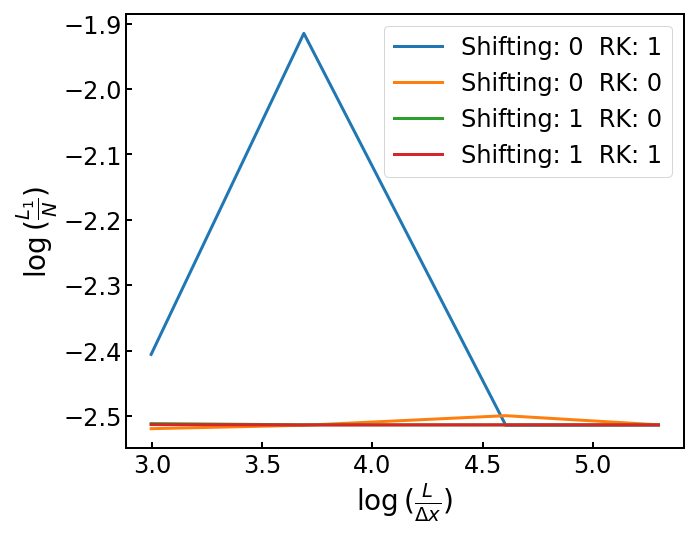

In [9]:
fig = plt.figure()


for i in df["Shifting"].unique():
    df_1 = df[df["Shifting"]==i]
    for j in df_1["RK"].unique():
        df_2 = df_1[df_1["RK"]==j]
        label = "Shifting: " + i + "  " +"RK: " + j
        plt.plot(df_2["log_Resolution"],df_2["log_Error"],label=label)
        print(df_2)
        
plt.legend()
plt.ylabel(r"$\log{(\frac{L_1}{N})}$")
plt.xlabel(r"$\log{(\frac{L}{\Delta x})}$")